# Experiments - PyMC, PyStan and TFP

In this notebook we compare three probabilistic programming libraries (PyStan, PyMC and TFP) over the Palmer Penguins dataset.

## 0. Set-up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymc as pm
import arviz as az
import stan 
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

In [2]:
penguins = pd.read_csv("penguins.csv")
penguins.head()

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [3]:
penguins = penguins.copy()[['species',
                        'bill_length_mm',
                        'bill_depth_mm',
                        'flipper_length_mm',
                        'body_mass_g']]
                        
penguins.dropna(inplace=True)
penguins.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0


In [4]:
train, test = train_test_split(penguins, test_size=0.3, random_state=2)

print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (239, 5)
Test shape: (103, 5)


In [5]:
K = 4

In [6]:
species = ['Adelie', 'Chinstrap']
ind_vars = ["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]

p1 = train[train['species'].isin(species)]
y_train = ((p1['species'] == species[0])*1).values
N1=len(y_train)
x_train = p1[ind_vars].values.reshape((N1, K))

In [7]:
x_train = (x_train - x_train.mean(axis=0))/x_train.std(axis=0)

In [8]:
p1 = test[test['species'].isin(species)]
y_test = ((p1['species'] == species[0])*1).values
N2=len(y_test)
x_test = p1[ind_vars].values.reshape((N2, K))

In [9]:
x_test = (x_test - x_train.mean(axis=0))/x_train.std(axis=0)

In [10]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, N1, N2

((160, 4), (160,), (59, 4), (59,), 160, 59)

In [11]:
def classify(x, alpha, beta0, beta1, beta2, beta3, threshold):
    """
    A simple classifying function
    """
    mu = alpha + beta0 * x[:,0]+ beta1 * x[:,1]+ beta2 * x[:,2] + beta3 * x[:,3]
    prob = 1 / (1 + np.exp(-mu))
    return prob, (prob > threshold).flatten()

### sklearn

In [12]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
print("Accuracy in train set: {}".format(clf.score(x_train, y_train)))
print("Accuracy in test set: {}".format(clf.score(x_test, y_test)))

Accuracy in train set: 0.98125
Accuracy in test set: 0.7288135593220338


In [13]:
alpha_sklearn = clf.intercept_
beta_sklearn = clf.coef_
print("Estimated parameters: alpha = {}, beta={}".format(alpha_sklearn, beta_sklearn))

Estimated parameters: alpha = [1.58156914], beta=[[-3.87189673  0.85798685 -0.30265676  0.83661658]]


In [14]:
probs, y_hat_sklearn = classify(x_test, alpha_sklearn, beta_sklearn[0,0], beta_sklearn[0,1], beta_sklearn[0,2], beta_sklearn[0,3], 0.5)


### Pymc

In [15]:
start_time = time.time()
with pm.Model() as model_1:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=len(ind_vars))
    mu = alpha + pm.math.dot(x_train, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    bd = pm.Deterministic('bd', -alpha/beta[1]-beta[0]/beta[1]*x_train[:,0])  
    yl = pm.Bernoulli('yl', p=theta, observed=y_train)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_train = pm.sample(2000, step, start)#@, tune=2000)
tot_time = time.time() - start_time
print("PyMC ex_trainecution time: {}".format(tot_time))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 35 seconds.


PyMC ex_trainecution time: 51.09140706062317


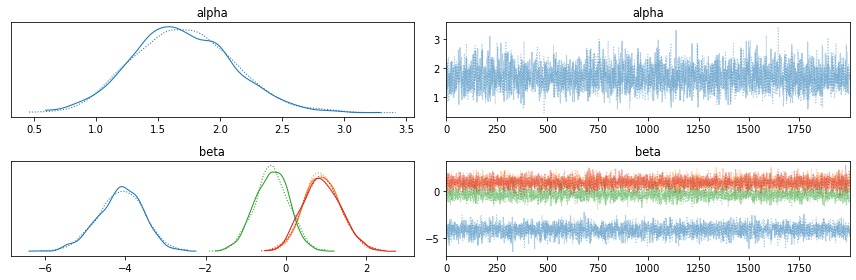

In [16]:
plots = az.plot_trace(trace_train, ['alpha','beta'])
plt.tight_layout()
plt.show()

In [17]:
alpha_pymc = np.mean(np.array(trace_train.posterior['alpha']).flatten())
beta_pymc = np.array(trace_train.posterior['beta'])
beta_pymc = beta_pymc.reshape(beta_pymc.shape[0]*beta_pymc.shape[1], beta_pymc.shape[2])
beta_pymc = np.mean(beta_pymc, axis=0)
beta_pymc

array([-4.12048747,  0.91791454, -0.35147282,  0.90307376])

In [18]:
beta_pymc, alpha_pymc

(array([-4.12048747,  0.91791454, -0.35147282,  0.90307376]),
 1.6999486524542267)

In [19]:
probs, y_hat_pymc = classify(x_test, alpha_pymc, beta_pymc[0], beta_pymc[1], beta_pymc[2], beta_pymc[3], 0.5)
probs, y_hat_pymc_out = classify(x_train, alpha_pymc, beta_pymc[0], beta_pymc[1], beta_pymc[2], beta_pymc[3],  0.5)

In [20]:
print("Accuracy in train set: {}".format(accuracy_score(y_hat_pymc_out, y_train)))
print("Accuracy in test set: {}".format(accuracy_score(y_hat_pymc, y_test)))

Accuracy in train set: 0.98125
Accuracy in test set: 0.7288135593220338


In [21]:
az.rhat(trace_train)

<xarray.Dataset>
Dimensions:     (beta_dim_0: 4, bd_dim_0: 160)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1 2 3
  * bd_dim_0    (bd_dim_0) int64 0 1 2 3 4 5 6 7 ... 153 154 155 156 157 158 159
Data variables:
    alpha       float64 0.9999
    beta        (beta_dim_0) float64 0.9998 1.0 1.0 0.9997
    bd          (bd_dim_0) float64 1.0 1.0 1.0 1.001 1.0 ... 1.0 1.0 1.001 1.0

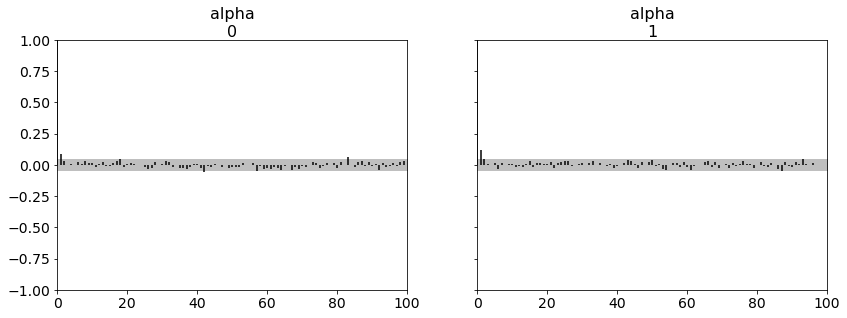

In [22]:
az.plot_autocorr(trace_train.posterior['alpha'])
plt.show()

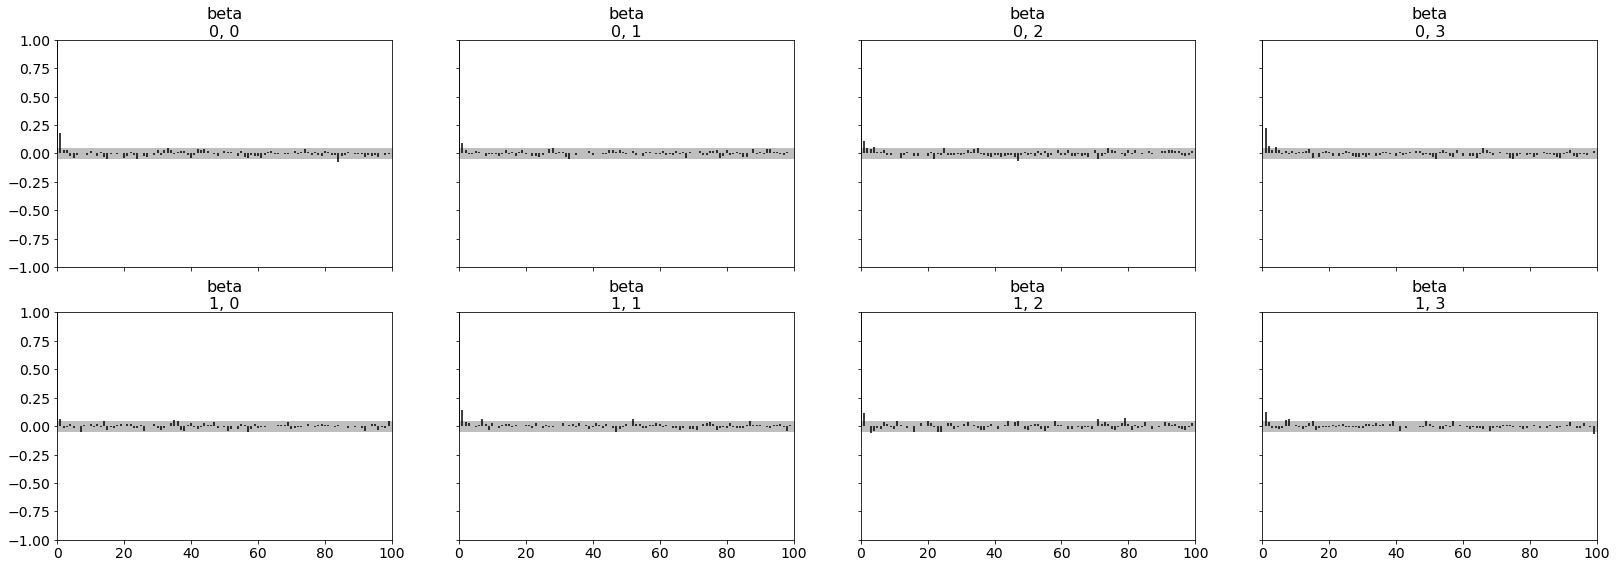

In [23]:
az.plot_autocorr(trace_train.posterior['beta'])
plt.show()

In [24]:
az.ess(trace_train)

<xarray.Dataset>
Dimensions:     (beta_dim_0: 4, bd_dim_0: 160)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1 2 3
  * bd_dim_0    (bd_dim_0) int64 0 1 2 3 4 5 6 7 ... 153 154 155 156 157 158 159
Data variables:
    alpha       float64 3.138e+03
    beta        (beta_dim_0) float64 3.194e+03 3.031e+03 3.215e+03 2.553e+03
    bd          (bd_dim_0) float64 3.059e+03 2.818e+03 ... 3.058e+03 2.889e+03

### PyStan

In [25]:
code = """                                                                                         
data {                                                                                               
  int N; //the number observations  
  int K; //the number of features                                                                    
  int y[N]; //the response                                                                           
  matrix[N,K] X; //the model matrix 
}                                                                                                    
parameters {                                                                                         
  real alpha;                                                                                        
  vector[K] beta; //the regression parameters                                                        
}                                                                                                    
transformed parameters {                                                                             
  vector[N] linpred;                                                                                 
  linpred = alpha+X*beta; 
  #vector[N] bd;
  #bd = -alpha/beta;
}                                                                                                    
model {                                                                                              
  alpha ~ normal(0,10); //prior for the intercept following Gelman 2008                              
                                                                                                   
  for(i in 1:K)                                                                                      
    beta[i] ~ normal(0,1);                                                                 
                                                                                                   
  y ~ bernoulli_logit(linpred);                                                                      
}
"""  

In [26]:
data = {                                                                                             
    'N': N1,
    'K': K,                                                                                        
    'y': y_train,                                                                                     
    'X': x_train, 
}  

In [27]:
posterior = stan.build(code, data=data, random_seed=1)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_kzaovq3b/model_exwp7fz5.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_kzaovq3b/model_exwp7fz5.stan', line 15, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_kzaovq3b/model_exwp7fz5.stan', line 16, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be do

In [28]:
start_time = time.time()
fit = posterior.sample(num_chains=2, num_samples=2000)
tot_time = time.time() - start_time
print("PyStan execution time: {}".format(tot_time))

Sampling:   0%
Sampling:  10% (600/6000)
Sampling:  15% (900/6000)
Sampling:  55% (3300/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.8 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.83 seconds.
  Adjust your expectations accordingly!


PyStan execution time: 2.7858543395996094


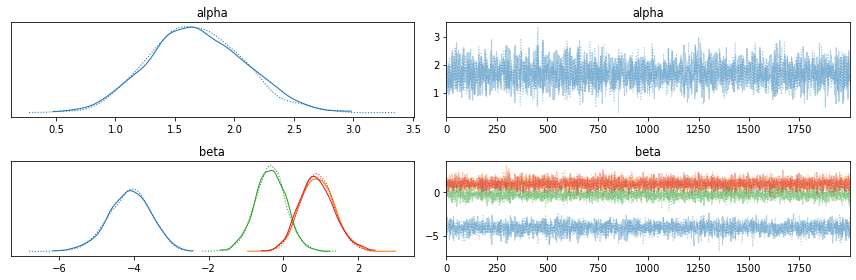

In [29]:
varnames = ['alpha', 'beta']
az.plot_trace(fit, varnames)
plt.tight_layout()
plt.show()

In [30]:
alpha_pystan = np.mean(fit['alpha'])
beta_pystan = np.mean(fit['beta'], axis=1)
alpha_pystan, beta_pystan

(1.6796405575582558,
 array([-4.1162132 ,  0.91374606, -0.34410108,  0.89898621]))

In [31]:
probs, y_hat_pystan = classify(x_test, alpha_pystan,  beta_pystan[0], beta_pystan[1], beta_pystan[2], beta_pystan[3], 0.5)
probs, y_hat_pystan_out = classify(x_train, alpha_pystan,  beta_pystan[0], beta_pystan[1], beta_pystan[2], beta_pystan[3], 0.5)

In [32]:
print("Accuracy in train set: {}".format(accuracy_score(y_hat_pystan_out, y_train)))
print("Accuracy in test set: {}".format(accuracy_score(y_hat_pystan, y_test)))

Accuracy in train set: 0.98125
Accuracy in test set: 0.7288135593220338


In [33]:
fit

<stan.Fit>
Parameters:
    alpha: ()
    beta: (4,)
    linpred: (160,)
Draws: 4000

In [34]:
az.rhat(fit)

<xarray.Dataset>
Dimensions:        (beta_dim_0: 4, linpred_dim_0: 160)
Coordinates:
  * beta_dim_0     (beta_dim_0) int64 0 1 2 3
  * linpred_dim_0  (linpred_dim_0) int64 0 1 2 3 4 5 ... 154 155 156 157 158 159
Data variables:
    alpha          float64 1.001
    beta           (beta_dim_0) float64 0.9997 1.0 1.0 1.001
    linpred        (linpred_dim_0) float64 1.001 1.003 1.001 ... 1.001 1.0 1.001

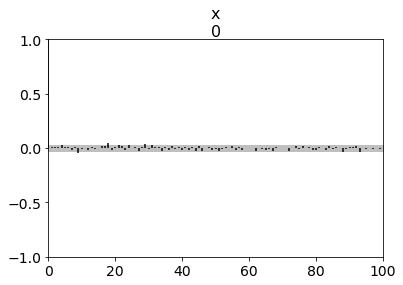

In [35]:
az.plot_autocorr(fit['alpha'])
plt.show()

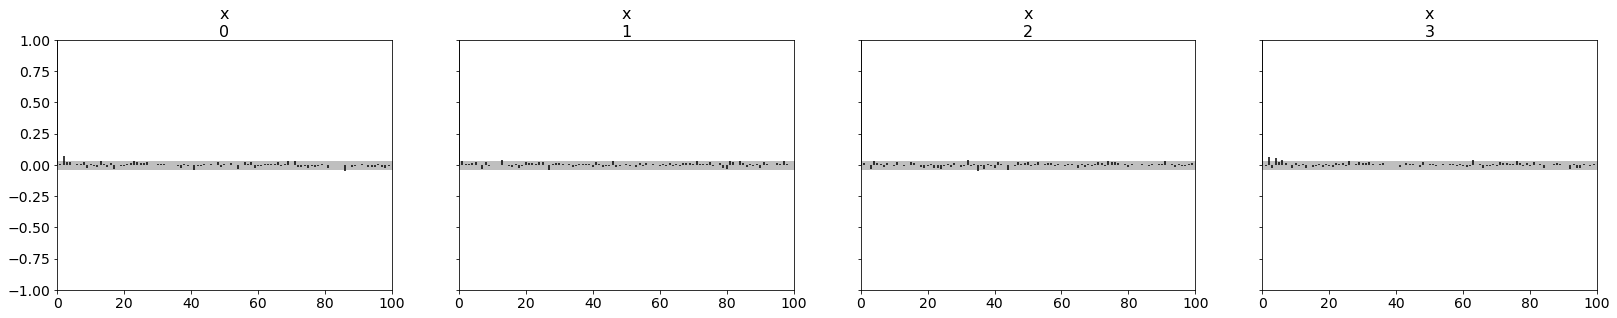

In [36]:
az.plot_autocorr(fit['beta'])
plt.show()

In [37]:
az.ess(fit)

<xarray.Dataset>
Dimensions:        (beta_dim_0: 4, linpred_dim_0: 160)
Coordinates:
  * beta_dim_0     (beta_dim_0) int64 0 1 2 3
  * linpred_dim_0  (linpred_dim_0) int64 0 1 2 3 4 5 ... 154 155 156 157 158 159
Data variables:
    alpha          float64 3.647e+03
    beta           (beta_dim_0) float64 3.269e+03 3.809e+03 3.777e+03 3.024e+03
    linpred        (linpred_dim_0) float64 3.641e+03 3.701e+03 ... 3.227e+03